# Data Mining Project
This notebook demonstrates the data preprocessing and analysis steps for the Bike Rentals dataset in San Jose. The goal is to clean the data, extract relevant features, and perform exploratory data analysis to derive insights.

## Step 1: Import Libraries and Load Data
In this step, we import the required Python libraries (like pandas) and load the datasets:
- `data_trip`: Contains trip data (start and end dates, stations, etc.).
- `data_weather`: Includes weather information during the trip period.
- `data_station`: Provides details about bike stations.

In [1]:
import pandas as pd
data_trip = pd.read_csv(r"C:\Users\utente\Desktop\UNITN\data mining\data bike rentals san jose\trip_data.csv")
data_weather = pd.read_csv(r"C:\Users\utente\Desktop\UNITN\data mining\data bike rentals san jose\weather_data.csv")
data_station = pd.read_csv(r"C:\Users\utente\Desktop\UNITN\data mining\data bike rentals san jose\station_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\utente\\Desktop\\UNITN\\data mining\\data bike rentals san jose\\trip_data.csv'

## Step 2: Inspect the Data
To understand the structure of the datasets, we display the first 5 rows and the number of rows in each dataset.

In [21]:
print(data_trip.head(5))
print(len(data_trip))

print(data_weather.head(5))
print(len(data_weather))

print(data_station.head(5))
print(len(data_station))

   Trip ID        Start Date  Start Station          End Date  End Station  \
0   913460  31/08/2015 23:26             50  31/08/2015 23:39           70   
1   913459  31/08/2015 23:11             31  31/08/2015 23:28           27   
2   913455  31/08/2015 23:13             47  31/08/2015 23:18           64   
3   913454  31/08/2015 23:10             10  31/08/2015 23:17            8   
4   913453  31/08/2015 23:09             51  31/08/2015 23:22           60   

  Subscriber Type  
0      Subscriber  
1      Subscriber  
2      Subscriber  
3      Subscriber  
4        Customer  
354152
         Date  Max TemperatureF  Mean TemperatureF  Min TemperatureF  \
0  01/09/2014              83.0               70.0              57.0   
1  02/09/2014              72.0               66.0              60.0   
2  03/09/2014              76.0               69.0              61.0   
3  04/09/2014              74.0               68.0              61.0   
4  05/09/2014              72.0             

In [22]:
print(data_trip.columns)


Index(['Trip ID', 'Start Date', 'Start Station', 'End Date', 'End Station',
       'Subscriber Type'],
      dtype='object')


## Step 3: Preprocessing Trip Data
We process the `Start Date` and `End Date` columns to extract:
- **Start_date**: The date when the trip started.
- **Start_time**: The time when the trip started.
- **End_date**: The date when the trip ended.
- **End_time**: The time when the trip ended.
The original `Start Date` and `End Date` columns are dropped after extraction.

In [23]:
# Substitute "Start Date" with "Start_date" and "Start_time" columns
data_trip["Start Date"] = pd.to_datetime(data_trip["Start Date"], dayfirst=True)

data_trip["Start_date"] = data_trip["Start Date"].dt.date
data_trip["Start_time"] = data_trip["Start Date"].dt.time

data_trip = data_trip.drop(columns=["Start Date"])

# Substitute "End Date" with "End_date" and "End_time" columns
data_trip["End Date"] = pd.to_datetime(data_trip["End Date"], dayfirst=True)

data_trip["End_date"] = data_trip["End Date"].dt.date
data_trip["End_time"] = data_trip["End Date"].dt.time

data_trip = data_trip.drop(columns=["End Date"])

## Step 6: Merging Datasets
In this step, we combine the datasets to create a unified view:
1. **Merge `data_trip` and `data_weather`:**
   - Merge on `Start_date` from `data_trip` and `Date` from `data_weather`.
   - Use an inner join to retain only matching rows.
2. **Merge `merged_data` with `data_station`:**
   - Merge on `Start Station` from `data_trip` and `Id` from `data_station`.
   - Use an inner join to include station details.

This process creates a combined dataset that links trips, weather data, and station information.

In [24]:
# Merge datasets data and data weather based on start_date
data_trip["Start_date"] = pd.to_datetime(data_trip["Start_date"], dayfirst=True)
data_weather["Date"] = pd.to_datetime(data_weather["Date"], dayfirst=True)

merged_data = pd.merge(data_trip, data_weather, left_on="Start_date", right_on="Date", 
                       how="inner")

merged_data2 = pd.merge(merged_data, data_station[["Id", "Name", "City"]], 
                        left_on="Start Station", right_on="Id", how="inner")

In [29]:
print("Final dataset:")
print(merged_data2.head(4), "\n")
print("Columns of the final dataset:")
print(merged_data2.columns)
print(merged_data2["City"].value_counts())
print(merged_data2["Subscriber Type"].value_counts())
print(len(merged_data2))

Final dataset:
   Trip ID  Start Station  End Station Subscriber Type Start_date Start_time  \
0   913460             50           70      Subscriber 2015-08-31   23:26:00   
1   913460             50           70      Subscriber 2015-08-31   23:26:00   
2   913460             50           70      Subscriber 2015-08-31   23:26:00   
3   913460             50           70      Subscriber 2015-08-31   23:26:00   

     End_date  End_time       Date  Max TemperatureF  ...  Mean Wind SpeedMPH  \
0  2015-08-31  23:39:00 2015-08-31              78.0  ...                 9.0   
1  2015-08-31  23:39:00 2015-08-31              80.0  ...                 4.0   
2  2015-08-31  23:39:00 2015-08-31              82.0  ...                 8.0   
3  2015-08-31  23:39:00 2015-08-31              82.0  ...                 6.0   

   Max Gust SpeedMPH  PrecipitationIn  CloudCover  Events  WindDirDegrees  \
0               21.0              0.0         1.0     NaN           246.0   
1               20.0    

## Step 1: Data Preprocessing with Spark
In this step I load, clean and merge datasets using Spark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, to_date, date_format, when, count, desc, round, lit, sum, dayofweek, unix_timestamp, avg, hour, floor #ultimo non serve, avg, expr
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("BikeShare Data Preprocessing").getOrCreate()

#### Step 1.1: Load datasets

In [3]:
trip_data = spark.read.csv(r"C:\Users\utente\Desktop\UNITN\data mining\Project\data bike rentals san jose\trip_data.csv", header=True, inferSchema=True)
station_data = spark.read.csv(r"C:\Users\utente\Desktop\UNITN\data mining\Project\data bike rentals san jose\station_data.csv", header=True, inferSchema=True)
weather_data = spark.read.csv(r"C:\Users\utente\Desktop\UNITN\data mining\Project\data bike rentals san jose\weather_data.csv", header=True, inferSchema=True)

#### Step 1.2: Preprocessing using PySpark
TRIP DATA:
We process the `Start Date` and `End Date` columns to extract:
- **Start_date**: The date when the trip started.
- **Start_time**: The time when the trip started.
- **End_date**: The date when the trip ended.
- **End_time**: The time when the trip ended.

The original `Start Date` and `End Date` columns are dropped after extraction.

In [4]:
# Convert "Start Date" and "End Date" to timestamp 
trip_data = trip_data.withColumn("Start Date", to_timestamp(col("Start Date"), "dd/MM/yyyy HH:mm")) \
                     .withColumn("End Date", to_timestamp(col("End Date"), "dd/MM/yyyy HH:mm"))

# Extract Start_date and Start_time
trip_data = trip_data.withColumn("Start_date", to_date(col("Start Date"))) \
                     .withColumn("Start_time", date_format(col("Start Date"), "HH:mm:ss"))

# Extract End_date and End_time
trip_data = trip_data.withColumn("End_date", to_date(col("End Date"))) \
                     .withColumn("End_time", date_format(col("End Date"), "HH:mm:ss"))

trip_data = trip_data.drop("Start Date", "End Date")
# trip_data.show(5)

WEATHER DATA: Convert the Date column to date type (necessary for comparison with other dates)

In [5]:
weather_data = weather_data.withColumn("Date", to_date(col("Date"), "dd/MM/yyyy"))
# weather_data.select("Date").show(5)

STATION DATA: Define the city-to-zip mapping directly as a dictionary and replace the `City` column with mapped Zip codes

In [6]:
city_to_zip = {
    "San Francisco": "94107",
    "Redwood City": "94063",
    "Palo Alto": "94301",
    "Mountain View": "94041",
    "San Jose": "95113"
}

# Start with the existing DataFrame
station_data_updated = station_data

# Replace city values with zip codes
for city, zip_code in city_to_zip.items():
    station_data_updated = station_data_updated.withColumn(
        "city",
        when(col("city") == city, zip_code).otherwise(col("city"))
    )


In [7]:
# to be deleted
# Convert a sample to Pandas for easier inspection
station_data_updated.limit(5).toPandas()


,Id,Name,Lat,Long,Dock Count,city
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,95113
1,3,San Jose Civic Center,37.330698,-121.888979,15,95113
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,95113
3,5,Adobe on Almaden,37.331415,-121.893200,19,95113
4,6,San Pedro Square,37.336721,-121.894074,15,95113


#### Step 1.3: Merge datasets using SQL queries

In [8]:
# Register dataframes as temporary SQL views
trip_data.createOrReplaceTempView("trip")
weather_data.createOrReplaceTempView("weather")
station_data_updated.createOrReplaceTempView("station") 

In [9]:
# to be deleted
print(f"Trip data rows: {trip_data.count()}")
print(f"Weather data rows: {weather_data.count()}")
print(f"Station data rows: {station_data.count()}")

Trip data rows: 354152
Weather data rows: 1825
Station data rows: 76


In [10]:
final_data = spark.sql("""
    SELECT DISTINCT
        -- Trip details
        t.`Trip ID`, t.`Start Station`, t.`End Station`, t.`Subscriber Type`, t.`Start_date`, 
        t.`End_date`, t.`Start_time`, t.`End_time`, 
        
        -- Weather details
        w.`Max TemperatureF`, w.`Mean TemperatureF`, w.`Min TemperatureF`, w.`Max Dew PointF`,     
        w.`MeanDew PointF`, w.`Min DewpointF`, w.`Max Humidity`, w.`Mean Humidity`,     
        w.`Min Humidity`, w.`Max Sea Level PressureIn`, w.`Mean Sea Level PressureIn`, 
        w.`Min Sea Level PressureIn`, w.`Max VisibilityMiles`, w.`Mean VisibilityMiles`, 
        w.`Min VisibilityMiles`, w.`Max Wind SpeedMPH`, w.`Mean Wind SpeedMPH`, w.`Max Gust SpeedMPH`,
        w.`PrecipitationIn`, w.`CloudCover`, w.`WindDirDegrees`, w.`Events`, w.`Zip`,
                       
        -- Station details
        s1.Name AS Start_Station_Name, s1.City AS Start_Station_City, s1.Lat AS Start_Lat,
        s1.Long AS Start_Long, s1.`Dock Count` AS Start_dock_count,
        s2.Name AS End_Station_Name, s2.City AS End_Station_City, s2.Lat AS End_Lat,
        s2.Long AS End_Long, s2.`Dock Count` AS End_dock_count
    FROM 
        trip t
    INNER JOIN station s1 ON t.`Start Station` = s1.Id
    INNER JOIN station s2 ON t.`End Station` = s2.Id
    INNER JOIN weather w 
        ON t.Start_date = w.Date AND s1.City = w.`Zip`
"""
)

# Show the final merged data
final_data.show(5)


+-------+-------------+-----------+---------------+----------+----------+----------+--------+----------------+-----------------+----------------+--------------+--------------+-------------+------------+-------------+------------+------------------------+-------------------------+------------------------+-------------------+--------------------+-------------------+-----------------+------------------+-----------------+---------------+----------+--------------+-----------------+-----+--------------------+------------------+---------+-----------+----------------+------------------+----------------+---------+-----------+--------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|  End_date|Start_time|End_time|Max TemperatureF|Mean TemperatureF|Min TemperatureF|Max Dew PointF|MeanDew PointF|Min DewpointF|Max Humidity|Mean Humidity|Min Humidity|Max Sea Level PressureIn|Mean Sea Level PressureIn|Min Sea Level PressureIn|Max VisibilityMiles|Mean VisibilityMiles|Min Visibility

In [11]:
# to be deleted
print(f"Final data rows: {final_data.count()}")

Final data rows: 354152


#### Step 1.4: Inspect missing values (still to decide what to do about it)

In [11]:
# Count missing values for all columns
missing_values = final_data.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in final_data.columns]
)

# Show the count of missing values for each column
missing_values.show()


+-------+-------------+-----------+---------------+----------+--------+----------+--------+----------------+-----------------+----------------+--------------+--------------+-------------+------------+-------------+------------+------------------------+-------------------------+------------------------+-------------------+--------------------+-------------------+-----------------+------------------+-----------------+---------------+----------+--------------+------+---+------------------+------------------+---------+----------+----------------+----------------+----------------+-------+--------+--------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|End_date|Start_time|End_time|Max TemperatureF|Mean TemperatureF|Min TemperatureF|Max Dew PointF|MeanDew PointF|Min DewpointF|Max Humidity|Mean Humidity|Min Humidity|Max Sea Level PressureIn|Mean Sea Level PressureIn|Min Sea Level PressureIn|Max VisibilityMiles|Mean VisibilityMiles|Min VisibilityMiles|Max Wind SpeedMPH|Mea

In [12]:
# Filter rows with missing weather data
missing_weather_rows = final_data.filter(
    (col("Max TemperatureF").isNull()) |
    (col("Mean TemperatureF").isNull())|
    (col("Min TemperatureF").isNull())
)

missing_weather_rows.groupBy("Start_date").count().orderBy(desc("count")).show()

+----------+-----+
|Start_date|count|
+----------+-----+
|2015-05-01|   33|
|2015-08-08|   14|
|2015-05-03|   11|
|2015-05-02|    8|
+----------+-----+



From this output we learn that missing values in temperature are due to the fact that for some specific days we dont have weather info, these days are the 4 in the output.

In [13]:
# Filter rows with missing weather data
missing_weather_rows = final_data.filter(
    (col("Max TemperatureF").isNull()) |
    (col("Mean TemperatureF").isNull())|
    (col("Min TemperatureF").isNull())|
    (col("Max Dew PointF").isNull()) |
    (col("MeanDew PointF").isNull())|
    (col("Min DewpointF").isNull())
)

missing_weather_rows.groupBy("Start_date").count().orderBy(desc("count")).show(10)

+----------+-----+
|Start_date|count|
+----------+-----+
|2015-05-01|   33|
|2015-08-08|   14|
|2014-09-10|   14|
|2014-12-08|   14|
|2014-11-10|   13|
|2014-10-14|   12|
|2014-11-25|   11|
|2015-05-03|   11|
|2014-11-24|   11|
|2014-09-19|   11|
+----------+-----+
only showing top 10 rows



Looking at other variables for weather many more days present missing values. I could do imputation using the days close to the missing ones (?)

#### Step 1.5: Implement MapReduce for different tasks
- Identify the stations with the highest combined activity (pickups and returns)

In [23]:
#   WITHOUT USING MAPREDUCE IMPLEMENTATION
# Count of rentals starting and ending from and at each station
rentals_by_start_station = final_data.groupBy("Start Station").count().withColumnRenamed("count", "Start Rentals")

rentals_by_end_station = final_data.groupBy("End Station").count().withColumnRenamed("count", "End Rentals")

# Rename columns to standardize "Station" before the join
rentals_by_start_station = rentals_by_start_station.withColumnRenamed("Start Station", "Station") \
                                                   .withColumnRenamed("Start Rentals", "Pickups")

rentals_by_end_station = rentals_by_end_station.withColumnRenamed("End Station", "Station") \
                                               .withColumnRenamed("End Rentals", "Returns")

# Perform the outer join on "Station"
busiest_stations = rentals_by_start_station.join(
    rentals_by_end_station,
    on="Station",
    how="outer"
).fillna(0)  # Replace null values with 0

# Add a new column for total activity
busiest_stations = busiest_stations.withColumn("Total Activity", col("Pickups") + col("Returns"))

# Order by Total Activity in descending order
busiest_stations = busiest_stations.orderBy(col("Total Activity").desc())

# Show the results
print("Busiest Stations:")
busiest_stations.show(5)

Busiest Stations:
+-------+-------+-------+--------------+
|Station|Pickups|Returns|Total Activity|
+-------+-------+-------+--------------+
|     70|  26304|  34810|         61114|
|     50|  17255|  17810|         35065|
|     61|  14026|  15463|         29489|
|     60|  14158|  15065|         29223|
|     65|  13752|  15422|         29174|
+-------+-------+-------+--------------+
only showing top 5 rows



In [26]:
# 1. Map Phase: Create key-value pairs for pickups and returns
pickups = final_data.select(
    col("Start Station").alias("Station")
).withColumn("Pickups", lit(1)).withColumn("Returns", lit(0))

returns = final_data.select(
    col("End Station").alias("Station")
).withColumn("Returns", lit(1)).withColumn("Pickups", lit(0))

# 2. Shuffle Phase: Combine all records by station
# Ensure both DataFrames have the same schema
combined = pickups.unionByName(returns)

# 3. Reduce Phase: Aggregate counts for pickups and returns
station_activity = combined.groupBy("Station").agg(
    sum("Pickups").alias("Pickups"),
    sum("Returns").alias("Returns")
)

# 4. Add Total Activity Column
station_activity = station_activity.withColumn(
    "Total Activity", col("Pickups") + col("Returns")
)

# 5. Sort by Total Activity in Descending Order
busiest_stations = station_activity.orderBy(col("Total Activity").desc())

# Show the results
busiest_stations.show(5)


+-------+-------+-------+--------------+
|Station|Pickups|Returns|Total Activity|
+-------+-------+-------+--------------+
|     70|  26304|  34810|         61114|
|     50|  17255|  17810|         35065|
|     61|  14026|  15463|         29489|
|     60|  14158|  15065|         29223|
|     65|  13752|  15422|         29174|
+-------+-------+-------+--------------+
only showing top 5 rows



The top 5 busiest stations are 70, 50, 61, 60, 65

- IDENTIFY THE MOST POPULAR ROUTES:
Instead of looking at stations individually, analyze the most frequently traveled routes (Start Station → End Station) to understand the most commonly used paths

In [29]:
#   WITHOUT USING MAPREDUCE 
# Group by Start Station and End Station to count routes
popular_routes = final_data.groupBy("Start Station", "End Station").count().withColumnRenamed("count", "Trip Count")

# Sort by Trip Count in descending order
popular_routes = popular_routes.orderBy(col("Trip Count").desc())

popular_routes.show(5)

+-------------+-----------+----------+
|Start Station|End Station|Trip Count|
+-------------+-----------+----------+
|           50|         60|      3145|
|           61|         50|      2973|
|           50|         61|      2640|
|           51|         70|      2439|
|           74|         61|      2356|
+-------------+-----------+----------+
only showing top 5 rows



In [31]:
# 1. Map Phase: Create key-value pairs for routes
routes = final_data.select(col("Start Station"), col("End Station")).withColumn("Count", lit(1))

# 2. Shuffle and Reduce Phase: Group by route and sum counts
route_counts = routes.groupBy("Start Station", "End Station").agg(sum("Count").alias("Trip Count"))

# 3. Sort by Trip Count in descending order
popular_routes = route_counts.orderBy(col("Trip Count").desc())

popular_routes.show(5)


+-------------+-----------+----------+
|Start Station|End Station|Trip Count|
+-------------+-----------+----------+
|           50|         60|      3145|
|           61|         50|      2973|
|           50|         61|      2640|
|           51|         70|      2439|
|           74|         61|      2356|
+-------------+-----------+----------+
only showing top 5 rows



The top 5 busiest stations are 70, 50, 61, 60, 65. Intuitlively the most common routes are the one between those stations

- TRIPS BY WEEK DAY: Analyze how trip volume varies by the day of the week.

In [ ]:
# Add a column for the weekday number (1 = Sunday, ..., 7 = Saturday)
final_data = final_data.withColumn("Start_weekday_num", dayofweek(col("Start_date")))

# Remap weekday numbers so Monday = 1, Sunday = 7
final_data = final_data.withColumn(
    "Start_weekday_mapped",
    when(col("Start_weekday_num") == 2, 1)  # Monday
    .when(col("Start_weekday_num") == 3, 2)  # Tuesday
    .when(col("Start_weekday_num") == 4, 3)  # Wednesday
    .when(col("Start_weekday_num") == 5, 4)  # Thursday
    .when(col("Start_weekday_num") == 6, 5)  # Friday
    .when(col("Start_weekday_num") == 7, 6)  # Saturday
    .when(col("Start_weekday_num") == 1, 7)  # Sunday
)

# Map the new weekday numbers to their names
final_data = final_data.withColumn(
    "Start_weekday",
    when(col("Start_weekday_mapped") == 1, "Monday")
    .when(col("Start_weekday_mapped") == 2, "Tuesday")
    .when(col("Start_weekday_mapped") == 3, "Wednesday")
    .when(col("Start_weekday_mapped") == 4, "Thursday")
    .when(col("Start_weekday_mapped") == 5, "Friday")
    .when(col("Start_weekday_mapped") == 6, "Saturday")
    .when(col("Start_weekday_mapped") == 7, "Sunday")
)

# Group by the new weekday column and include mapped values
trips_by_weekday = final_data.groupBy("Start_weekday", "Start_weekday_mapped").count().withColumnRenamed("count", "Total Trips")

# Sort by Start_weekday_mapped to ensure Monday is first
trips_by_weekday = trips_by_weekday.orderBy("Start_weekday_mapped")

trips_by_weekday.show()


+-------------+--------------------+-----------+
|Start_weekday|Start_weekday_mapped|Total Trips|
+-------------+--------------------+-----------+
|       Monday|                   1|      63718|
|      Tuesday|                   2|      66503|
|    Wednesday|                   3|      65285|
|     Thursday|                   4|      63184|
|       Friday|                   5|      57808|
|     Saturday|                   6|      20935|
|       Sunday|                   7|      16719|
+-------------+--------------------+-----------+



- AVERAGE TRIP DURATION BY STATION

In [38]:
# Convert to timestamp
final_data = final_data.withColumn("Start_time", to_timestamp(col("Start_time"))) \
                       .withColumn("End_time", to_timestamp(col("End_time")))

# Calculate trip duration in minutes
final_data = final_data.withColumn("Trip_Duration", 
    (unix_timestamp(col("End_time")) - unix_timestamp(col("Start_time"))) / 60)

# Average trip duration by Start Station
avg_trip_duration_start = final_data.groupBy("Start Station").agg(
    avg("Trip_Duration").alias("Avg Trip Duration (mins)")
).withColumnRenamed("Start Station", "Station").withColumn("Station Type", lit("Start"))

# Average trip duration by End Station
avg_trip_duration_end = final_data.groupBy("End Station").agg(
    avg("Trip_Duration").alias("Avg Trip Duration (mins)")
).withColumnRenamed("End Station", "Station").withColumn("Station Type", lit("End"))

# Combine results for Start and End Stations
avg_trip_duration_combined = avg_trip_duration_start.union(avg_trip_duration_end)

# Sort by Avg Trip Duration in descending order
avg_trip_duration_combined = avg_trip_duration_combined.withColumn("Avg Trip Duration (mins)", round(col("Avg Trip Duration (mins)"), 2)).orderBy(col("Avg Trip Duration (mins)").desc())

print("Average Trip Duration by Station (Start and End):")
avg_trip_duration_combined.show(5)


Average Trip Duration by Station (Start and End):
+-------+------------------------+------------+
|Station|Avg Trip Duration (mins)|Station Type|
+-------+------------------------+------------+
|     35|                   50.69|         End|
|     25|                   50.11|       Start|
|     35|                   41.34|       Start|
|     83|                   30.52|         End|
|     36|                    30.4|         End|
+-------+------------------------+------------+
only showing top 5 rows



In [39]:
# 1. Map Phase: Calculate Trip Duration and Create Key-Value Pairs
mapped_start = final_data.withColumn("Trip_Duration", 
    (unix_timestamp(col("End_time")) - unix_timestamp(col("Start_time"))) / 60
).select(
    col("Start Station").alias("Station"),
    col("Trip_Duration"),
    lit("Start").alias("Station Type")
)

mapped_end = final_data.withColumn("Trip_Duration", 
    (unix_timestamp(col("End_time")) - unix_timestamp(col("Start_time"))) / 60
).select(
    col("End Station").alias("Station"),
    col("Trip_Duration"),
    lit("End").alias("Station Type")
)

# 2. Shuffle Phase: Combine Start and End Station Data
combined_data = mapped_start.union(mapped_end)

# 3. Reduce Phase: Aggregate to Calculate Averages
avg_trip_duration_combined = combined_data.groupBy("Station", "Station Type").agg(
    (sum("Trip_Duration") / count("Trip_Duration")).alias("Avg Trip Duration (mins)")
)

# 4. Sort Phase: Sort by Average Trip Duration
avg_trip_duration_combined = avg_trip_duration_combined.orderBy(col("Avg Trip Duration (mins)").desc())

avg_trip_duration_combined.show(5)


+-------+------------+------------------------+
|Station|Station Type|Avg Trip Duration (mins)|
+-------+------------+------------------------+
|     35|         End|      50.693370165745854|
|     25|       Start|      50.111111111111114|
|     35|       Start|      41.337190082644625|
|     83|         End|      30.517241379310345|
|     36|         End|      30.401209677419356|
+-------+------------+------------------------+
only showing top 5 rows



- Analyse how behaviours change between subscriber type

In [53]:
total_trips = final_data.count()

# Group by Subscriber Type and count trips
trips_by_user_type = final_data.groupBy("Subscriber Type").count().withColumnRenamed("count", "Total Trips")

# Add a percentage column to show the proportion of trips for each user type
trips_by_user_type = trips_by_user_type.withColumn(
    "Percentage of total trips",
    round((col("Total Trips") / total_trips) * 100, 2)
)

# Step 2: Calculate Average Trip Duration by Subscriber Type
avg_trip_duration_by_user_type = final_data.groupBy("Subscriber Type").agg(
    avg("Trip_Duration").alias("Avg Trip Duration (mins)")
).withColumn(
    "Avg Trip Duration (mins)", round(col("Avg Trip Duration (mins)"), 2)
)

# Step 3: Calculate Average Temperature by Subscriber Type
avg_temperature_by_user_type = final_data.groupBy("Subscriber Type").agg(
    avg((col("Mean TemperatureF") - 32) * 5 / 9).alias("Avg Temperature (C)")
).withColumn(
    "Avg Temperature (C)", round(col("Avg Temperature (C)"), 2)
)

# Step 4: Combine All Results
result = trips_by_user_type \
    .join(avg_trip_duration_by_user_type, on="Subscriber Type", how="inner") \
    .join(avg_temperature_by_user_type, on="Subscriber Type", how="inner")


print("Total Trips, Average Trip Duration, and Average Temperature by Subscriber Type:")
result.show()

Total Trips, Average Trip Duration, and Average Temperature by Subscriber Type:
+---------------+-----------+-------------------------+------------------------+-------------------+
|Subscriber Type|Total Trips|Percentage of total trips|Avg Trip Duration (mins)|Avg Temperature (C)|
+---------------+-----------+-------------------------+------------------------+-------------------+
|     Subscriber|     310217|                    87.59|                    8.11|              16.15|
|       Customer|      43935|                    12.41|                   38.54|              16.65|
+---------------+-----------+-------------------------+------------------------+-------------------+



In [40]:
# 1. Map Phase: Add a column with a constant value 1 to simulate trip counts
mapped_data = final_data.withColumn("Trip", lit(1))

# 2. Shuffle and Reduce Phase: Group by Subscriber Type and sum the Trip column
trips_by_user_type = mapped_data.groupBy("Subscriber Type").agg(
    sum("Trip").alias("Total Trips")
)

# 3. Calculate the total number of trips
total_trips = mapped_data.agg(sum("Trip").alias("Total Trips")).collect()[0]["Total Trips"]

# 4. Add a percentage column
trips_by_user_type = trips_by_user_type.withColumn(
    "Percentage",
    round((col("Total Trips") / total_trips) * 100, 2)
)

print("Trips by Subscriber Type with Percentage:")
trips_by_user_type.show()


Trips by Subscriber Type with Percentage:
+---------------+-----------+----------+
|Subscriber Type|Total Trips|Percentage|
+---------------+-----------+----------+
|     Subscriber|     310217|     87.59|
|       Customer|      43935|     12.41|
+---------------+-----------+----------+



- frequency of bike rentals by subscriber type for each hour of the day

In [57]:
# Extract hour from Start_time
final_data = final_data.withColumn("Start_hour", hour(col("Start_time")))

# Group by Subscriber Type and Start_hour
peak_hours_by_user_type = final_data.groupBy("Subscriber Type", "Start_hour").count().withColumnRenamed("count", "Total Trips")

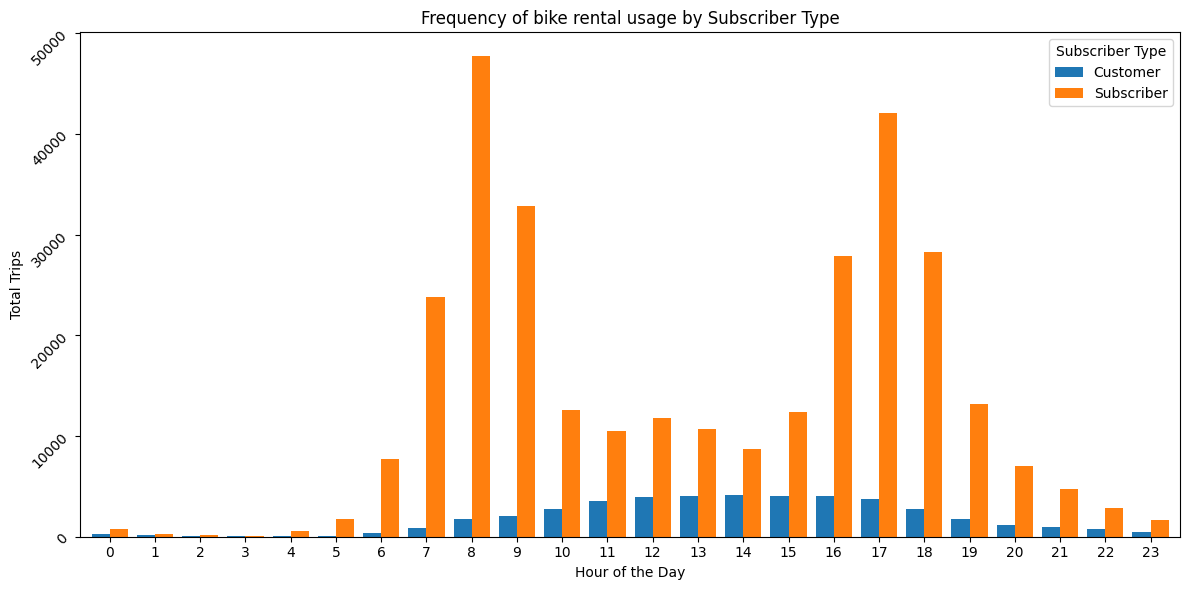

In [60]:
# Convert the PySpark DataFrame to a Pandas DataFrame
peak_hours_df = peak_hours_by_user_type.toPandas()

# Pivot the data for visualization
pivot_table = peak_hours_df.pivot(index="Start_hour", columns="Subscriber Type", values="Total Trips").fillna(0)

# Plot a histogram
pivot_table.plot(kind="bar", figsize=(12, 6), width=0.8)

# Customize the plot
plt.title("Frequency of bike rental usage by Subscriber Type")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Trips")
plt.xticks(rotation=0)
plt.yticks(rotation=45)
plt.legend(title="Subscriber Type")
plt.tight_layout()

plt.show()


try temperature per nr of trips

In [63]:
final_data.show(3)

+-------+-------------+-----------+---------------+----------+----------+-------------------+-------------------+----------------+-----------------+----------------+--------------+--------------+-------------+------------+-------------+------------+------------------------+-------------------------+------------------------+-------------------+--------------------+-------------------+-----------------+------------------+-----------------+---------------+----------+--------------+-----------------+-----+--------------------+------------------+---------+-----------+----------------+------------------+----------------+---------+-----------+--------------+-----------------+--------------------+-------------+-------------+----------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|  End_date|         Start_time|           End_time|Max TemperatureF|Mean TemperatureF|Min TemperatureF|Max Dew PointF|MeanDew PointF|Min DewpointF|Max Humidity|Mean Humidity|Min Humidity|Max Sea Level

In [73]:
# Step 1: Convert temperatures to Celsius and bin them
final_data = final_data.withColumn(
    "Temperature (C)", round((col("Mean TemperatureF") - 32) * 5 / 9, 2)
)

final_data = final_data.withColumn(
    "Temperature Bin", floor(col("Temperature (C)"))
)

# Step 2: Calculate the number of trips per temperature bin
trips_by_temperature = final_data.groupBy("Temperature Bin").agg(
    count("Trip ID").alias("Total Trips")
)

# Step 3: Calculate the percentage of trips for each temperature bin
total_trips = final_data.count()  # Total trips across all bins
trips_by_temperature = trips_by_temperature.withColumn(
    "Percentage of Trips",
    round((col("Total Trips") / total_trips) * 100, 2)
)

# Convert to Pandas for plotting
trips_by_temperature_pandas = trips_by_temperature.toPandas()


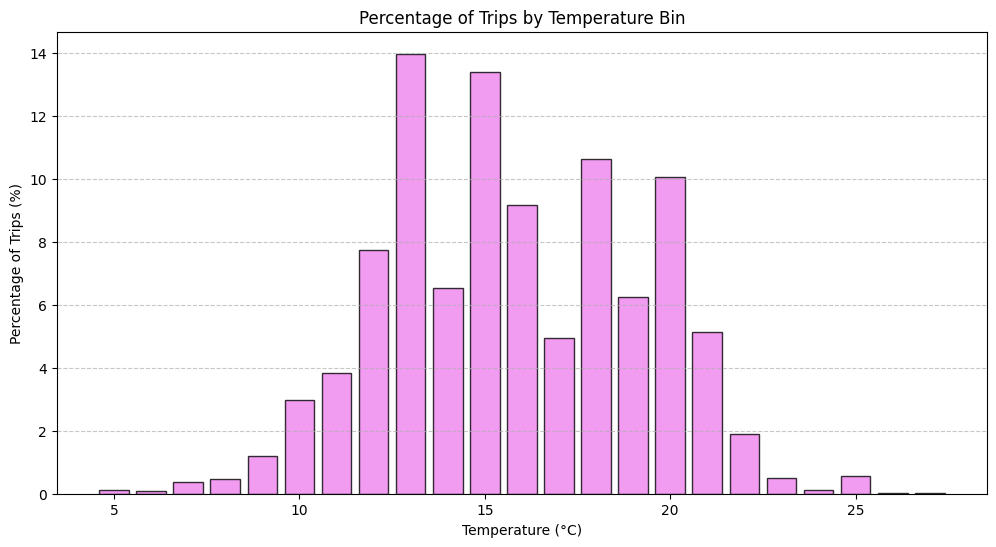

In [78]:
# Extract data for plotting
temperature_bins = trips_by_temperature_pandas["Temperature Bin"]
percentage_of_trips = trips_by_temperature_pandas["Percentage of Trips"]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(temperature_bins, percentage_of_trips, color='violet', edgecolor='black', alpha=0.8)

# Add labels and title
plt.xlabel("Temperature (°C)")
plt.ylabel("Percentage of Trips (%)")
plt.title("Percentage of Trips by Temperature Bin")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## END OF 1. DATA PREPROCESSING 

# 2. Station Importance Ranking Using PageRank

### Step 2.1. Preprocess the Dataset
Let's build the directed graph:

Nodes = unique bike stations.\
Edges = directed trips between stations (weighted by the frequency of trips).

In [12]:
from pyspark.sql import functions as F

# Group by start and end stations to calculate the number of trips (weights)
edge_weights = final_data.groupBy("Start Station", "End Station") \
    .agg(F.count("*").alias("weight"))

# Collect all unique stations (nodes)
nodes = edge_weights.select("Start Station").union(edge_weights.select("End Station")).distinct()

In [13]:
print(edge_weights.show(4))

+-------------+-----------+------+
|Start Station|End Station|weight|
+-------------+-----------+------+
|           65|         50|   827|
|           62|         87|   137|
|           68|         57|   270|
|           64|         48|   169|
+-------------+-----------+------+
only showing top 4 rows

None


#### Step 2.2 Build the Transition Matrix
Represent the trips as a transition matrix. Each element 𝑀𝑖𝑗 in the matrix represents the probability of moving from station 𝑗 to station 𝑖.

1- Calculate the total outgoing trips for each station.

2- Normalize edge weights to get probabilities.

In [14]:
# Calculate total outgoing trips for each station
total_outgoing = edge_weights.groupBy("Start Station") \
    .agg(F.sum("weight").alias("total_weight"))

# Join with edge weights to calculate probabilities
transition_df = edge_weights.join(total_outgoing, on="Start Station") \
    .withColumn("probability", round(F.col("weight") / F.col("total_weight"), 4))

# Transition matrix rows: Start Station, End Station, Probability
transition_df.show()

# weight represents the number of trips from the start station to the end station (frq of trips)
# total_weight is the total number of trips from start station to all other stations

+-------------+-----------+------+------------+-----------+
|Start Station|End Station|weight|total_weight|probability|
+-------------+-----------+------+------------+-----------+
|           65|         50|   827|       13752|     0.0601|
|           62|         87|   137|        7999|     0.0171|
|           68|         57|   270|        5523|     0.0489|
|           64|         48|   169|        9469|     0.0178|
|           49|         49|    48|        2202|     0.0218|
|            2|         80|    15|        4968|      0.003|
|           90|         64|    12|        1848|     0.0065|
|           45|         70|   621|        6014|     0.1033|
|           32|         27|    49|        1230|     0.0398|
|           51|         50|   155|        7596|     0.0204|
|           68|         74|   206|        5523|     0.0373|
|           10|          2|   295|         832|     0.3546|
|           47|         45|   113|        4705|      0.024|
|           71|         42|   256|      

#### Step 2.3. Implement the PageRank Algorithm
Use NumPy to compute PageRank iteratively.

Collect the transition_df data into a NumPy matrix.

In [15]:
import numpy as np

# Map stations to indices
station_list = nodes.collect()
station_to_index = {row[0]: idx for idx, row in enumerate(station_list)}
n = len(station_list)  # Total number of stations

# Initialize transition matrix with zeros
M = np.zeros((n, n))

# Fill in the transition probabilities
for row in transition_df.collect():
    start_idx = station_to_index[row["Start Station"]]
    end_idx = station_to_index[row["End Station"]]
    M[end_idx, start_idx] = row["probability"]  # Note: M[end][start] for directed edge

Initialize the PageRank Vector: use a uniform distribution to start.

In [16]:
v = np.ones(n) / n  # Uniform distribution

Iteratively Compute PageRank:

In [17]:
d = 0.85  # Damping factor
e = np.ones(n) / n  # Uniform jump vector

iterations = 100  # Number of iterations
for _ in range(iterations):
    v = d * (M @ v) + (1 - d) * e


Intuition behind v:\
The proportion of time a random biker would spend at station 𝑖 if they took an infinite number of trips.
A measure of the station’s connectivity and influence in the network.

Map the computed PageRank values back to the station names.

In [18]:
# Map indices back to station names
station_ranks = [(station_list[i][0], rank) for i, rank in enumerate(v)]
station_ranks.sort(key=lambda x: x[1], reverse=True)  # Sort by rank (descending)

# Display top 10 stations
print("Top 10 Stations by PageRank:")
for station, rank in station_ranks[:10]:
    print(f"Station: {station}, PageRank: {rank:.4f}")


Top 10 Stations by PageRank:
Station: 2, PageRank: 0.0520
Station: 70, PageRank: 0.0487
Station: 22, PageRank: 0.0359
Station: 28, PageRank: 0.0334
Station: 50, PageRank: 0.0266
Station: 65, PageRank: 0.0236
Station: 61, PageRank: 0.0228
Station: 60, PageRank: 0.0225
Station: 74, PageRank: 0.0212
Station: 4, PageRank: 0.0202


Why is PageRank Useful for Bike Stations?

- Identify Hubs: Stations with high PageRank are central hubs where many trips either start or end.\
- Optimize Operations: Knowing which stations are central can help prioritize bike redistribution efforts.\
- User Flow Insights: Understand patterns of user movement and how stations interact within the network.\
- Infrastructure Planning: Focus investments (e.g., adding docks or bikes) on high-importance stations.

# 3. K-Means

Cluster stations based on travel behavior of costumers and external factors like weather, location, and station characteristics.

1. Data Preparation

Extract and preprocess the data to make it suitable for clustering.\
Key Features to Extract:\
	•	Hourly rental frequency: Number of rentals starting or ending at each station per hour.\
	•	Weather conditions: Attributes like temperature, humidity, or precipitation at the time of rentals.\
	•	Station location: Latitude and longitude of each station.\
	•	Dock count: The number of available docks at each station.\
Preprocessing Steps:\
	•	Normalize numerical data (e.g., weather variables, dock counts) to bring all features to the same scale.\
	•	Encode categorical data, if any, into numerical form.


In [12]:
from pyspark.sql.functions import hour, col

# Extract the hour from Start_time in PySpark
final_data = final_data.withColumn("Start_hour", hour(col("Start_time")))

# Group by Start Station and calculate hourly rentals
hourly_rentals = final_data.groupBy("Start Station", "Start_hour").count().withColumnRenamed("count", "Hourly Rentals")

# Show results
hourly_rentals.show(5)


+-------------+----------+--------------+
|Start Station|Start_hour|Hourly Rentals|
+-------------+----------+--------------+
|           61|        13|          2560|
|           39|        11|          2580|
|           77|        23|           390|
|           28|        16|           580|
|            3|        22|            65|
+-------------+----------+--------------+
only showing top 5 rows



In [14]:
from pyspark.sql.functions import avg

# 2. Weather conditions (average temperature, precipitation, etc.)
weather_features = final_data.groupBy("Start Station").agg(
    avg("Max TemperatureF").alias("Avg Temperature"),
    avg("PrecipitationIn").alias("Avg Precipitation")
)

# 3. Station location (latitude and longitude)
station_location = final_data.select(
    col("Start Station").alias("Station"),
    col("Start_Lat").alias("Latitude"),
    col("Start_Long").alias("Longitude"),
    col("Start_dock_count").alias("Dock Count")
).dropDuplicates()

# 4. Combine all features into one DataFrame
features = hourly_rentals.join(weather_features, hourly_rentals["Start Station"] == weather_features["Start Station"], "inner") \
                         .drop(weather_features["Start Station"])

features = features.join(station_location, features["Start Station"] == station_location["Station"], "inner") \
                   .drop(station_location["Station"])

# Display the extracted features
features.show(5)


+----------+--------------+-------------+-----------------+--------------------+---------+-----------+----------+
|Start_hour|Hourly Rentals|Start Station|  Avg Temperature|   Avg Precipitation| Latitude|  Longitude|Dock Count|
+----------+--------------+-------------+-----------------+--------------------+---------+-----------+----------+
|        13|          2560|           61|71.88289819469836|0.012382648258550236|37.780526|-122.390288|        27|
|        11|          2580|           39|71.34022109722079|0.015709636813866907|37.783871|-122.408433|        19|
|        23|           390|           77|71.56566913130322| 0.01187650064750958|37.789625|-122.400811|        27|
|        16|           580|           28|72.03032167832168| 0.01452704514975415|37.394358|-122.076713|        23|
|        22|            65|            3|72.10512687726566|0.010932488360062085|37.330698|-121.888979|        15|
+----------+--------------+-------------+-----------------+--------------------+--------

In [16]:
features.printSchema()

root
 |-- Start_hour: integer (nullable = true)
 |-- Hourly Rentals: long (nullable = false)
 |-- Start Station: integer (nullable = true)
 |-- Avg Temperature: double (nullable = true)
 |-- Avg Precipitation: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Dock Count: integer (nullable = true)
 |-- Hourly Rentals_normalized: double (nullable = true)
 |-- Avg Temperature_normalized: double (nullable = true)
 |-- Avg Precipitation_normalized: double (nullable = true)
 |-- Latitude_normalized: double (nullable = true)
 |-- Longitude_normalized: double (nullable = true)
 |-- Dock Count_normalized: double (nullable = true)



In [18]:
from pyspark.sql.functions import col, min, max

# Feature columns to normalize
feature_columns = ["Hourly Rentals", "Avg Temperature", "Avg Precipitation", "Latitude", "Longitude", "Dock Count"]

# Create a dictionary to store min-max values for each feature
min_max_values = {}

# Compute min and max for each feature
for feature in feature_columns:
    min_val = features.select(min(col(feature))).first()[0]
    max_val = features.select(max(col(feature))).first()[0]
    min_max_values[feature] = (min_val, max_val)

# Perform normalization for each feature
for feature in feature_columns:
    min_val, max_val = min_max_values[feature]
    normalized_col = ((col(feature) - min_val) / (max_val - min_val)).alias(f"{feature}_normalized")
    features = features.withColumn(f"{feature}_normalized", normalized_col)

# Show the dataset with normalized features
#features.select("Station", *[f"{feature}_normalized" for feature in feature_columns]).show(5)


confirm all normalized features:

In [20]:
features.select("Hourly Rentals_normalized", "Avg Temperature_normalized").show(5)

+-------------------------+--------------------------+
|Hourly Rentals_normalized|Avg Temperature_normalized|
+-------------------------+--------------------------+
|      0.07801526717557251|        0.3290595929133167|
|      0.07862595419847328|       0.27992563709472684|
|     0.011755725190839695|        0.3003376902244467|
|     0.017557251908396947|        0.3424073073546299|
|      0.00183206106870229|        0.3491801661264452|
+-------------------------+--------------------------+
only showing top 5 rows



In [21]:
features.select("Latitude_normalized", "Longitude_normalized", "Dock Count_normalized").show(5)


+--------------------+--------------------+---------------------+
| Latitude_normalized|Longitude_normalized|Dock Count_normalized|
+--------------------+--------------------+---------------------+
|  0.9489640828733784| 0.05292787178848233|                  1.0|
|  0.9560056248131726|0.019425596144786395|                  0.5|
|  0.9681183400064902| 0.03349858291558382|                  1.0|
|  0.1360438533338328|  0.6319014780144178|                 0.75|
|0.002033521528800...|  0.9785267861264005|                 0.25|
+--------------------+--------------------+---------------------+
only showing top 5 rows



In [22]:
from pyspark.ml.feature import VectorAssembler

feature_columns = [f"{feature}_normalized" for feature in feature_columns]  # List of normalized columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
clustered_data = assembler.transform(features)

clustered_data.select("features").show(5, truncate=False)


+----------------------------------------------------------------------------------------------------------+
|features                                                                                                  |
+----------------------------------------------------------------------------------------------------------+
|[0.07801526717557251,0.3290595929133167,0.4650532117668796,0.9489640828733784,0.05292787178848233,1.0]    |
|[0.07862595419847328,0.27992563709472684,0.5900044080582953,0.9560056248131726,0.019425596144786395,0.5]  |
|[0.011755725190839695,0.3003376902244467,0.44604390396553295,0.9681183400064902,0.03349858291558382,1.0]  |
|[0.017557251908396947,0.3424073073546299,0.5455899952347201,0.1360438533338328,0.6319014780144178,0.75]   |
|[0.00183206106870229,0.3491801661264452,0.41058978001254776,0.0020335215288003286,0.9785267861264005,0.25]|
+----------------------------------------------------------------------------------------------------------+
only showing top 5 